In [1]:
import warnings
warnings.filterwarnings('ignore')

In [282]:
import numpy as np
from numpy.random import choice
from scipy.optimize import curve_fit

In [3]:
import matplotlib.pyplot as plt
from plotting import initialize_plot_settings
initialize_plot_settings()

In [4]:
from disloc import deform_dislocation
from utils import load_and_mask_results, rotate

In [5]:
ORIGIN_X = 321660
ORIGIN_Y = 4164942

In [490]:
filename = f'results/sfm/strike_slip/HSLSurvey101419_utm_s310.00_d90.00_dep100.00_ss1.00_ds0.00_ICP_w50.00_str25.00.pkl'
x, y, ux, uy, uz, residual, mask = load_and_mask_results(filename, iterations=2)
xx, yy = np.meshgrid(x, y)

## Convenience functions

In [223]:
def rmse(ypred, yobs):
    return np.sqrt(np.nanmean((ypred - yobs) ** 2))

In [6]:
def center_profiles(uobs, utrue, dx=25):
    n = len(uobs)
    idx = np.where(uobs == np.sign(uobs) * np.min(np.abs(uobs)))[0][0]
    xp = np.arange(2*(n - idx), dtype=float)
    xp -= np.mean(xp)
    x = dx * xp - dx / 2
    if 2*idx - n < 0:
        return x[np.abs(2*idx - n)+1:], uobs[np.abs(2*idx - n):], utrue[np.abs(2*idx - n):]        
    return x, uobs[(2*idx - n):], utrue[(2*idx - n):]

In [224]:
def model_1d(x, depth, s):
    delta = 89.999
    deltarad = np.deg2rad(delta)
    zeta = (x / depth) - (1 / np.tan(deltarad))
    u1 = (s/np.pi)*(np.cos(deltarad)*np.arctan(zeta) + (np.sin(deltarad) - zeta*np.cos(deltarad))/(1+np.power(zeta,2)))
    u2 = (-s/np.pi)*(np.sin(deltarad)*np.arctan(zeta) + (np.cos(deltarad) + zeta*np.sin(deltarad))/(1+np.power(zeta,2)))
    return u2

In [563]:
def model_2d(depth, slip_ds, slip_ss, strike=310, dip=89.999, x=x, y=y, origin_x=ORIGIN_X, origin_y=ORIGIN_Y):
    if x.ndim < 2:
        x, y = np.meshgrid(x, y)
    x0 = np.mean(x) if origin_x is None else origin_x
    y0 = np.mean(y) if origin_y is None else origin_y

    xt = x - x0
    yt = y - y0

    deltarad = np.deg2rad(dip)
    thetarad = np.deg2rad(strike)
    X1p = xt * np.cos(np.pi - thetarad) + yt * np.sin(np.pi - thetarad)
    Zeta = (X1p / depth) - (1 / np.tan(deltarad))
    u1 = (slip_ds / np.pi) * (
        np.cos(deltarad) * np.arctan(Zeta)
        + (np.sin(deltarad) - Zeta * np.cos(deltarad)) / (1 + np.power(Zeta, 2))
    )
    u3 = (-slip_ds / np.pi) * (
        np.sin(deltarad) * np.arctan(Zeta)
        + (np.cos(deltarad) + Zeta * np.sin(deltarad)) / (1 + np.power(Zeta, 2))
    )
    u2 = (slip_ss / np.pi) * (
        np.arctan2(
            Zeta * np.power(np.sin(deltarad), 2),
            (1 - Zeta * np.sin(deltarad) * np.cos(deltarad)),
        )
        + (deltarad - np.sign(deltarad) * np.pi / 2.0)
    )

    u1p = u1 * np.cos(thetarad - np.pi) + u2 * np.sin(thetarad - np.pi)
    u2p = -u1 * np.sin(thetarad - np.pi) + u2 * np.cos(thetarad - np.pi)
    
    up, un = rotate(u1p, u2p, theta=50)
    
    return up, u3

In [535]:
def model_2d_profile(depth, slip_ds, slip_ss, strike=310, dip=89.999, x=x, y=y, origin_x=ORIGIN_X, origin_y=ORIGIN_Y):
    if x.ndim < 2:
        x, y = np.meshgrid(x, y)
    x0 = np.mean(x) if origin_x is None else origin_x
    y0 = np.mean(y) if origin_y is None else origin_y

    xt = x - x0
    yt = y - y0

    deltarad = np.deg2rad(dip)
    thetarad = np.deg2rad(strike)
    X1p = xt * np.cos(np.pi - thetarad) + yt * np.sin(np.pi - thetarad)
    Zeta = (X1p / depth) - (1 / np.tan(deltarad))
    u1 = (slip_ds / np.pi) * (
        np.cos(deltarad) * np.arctan(Zeta)
        + (np.sin(deltarad) - Zeta * np.cos(deltarad)) / (1 + np.power(Zeta, 2))
    )
    u3 = (-slip_ds / np.pi) * (
        np.sin(deltarad) * np.arctan(Zeta)
        + (np.cos(deltarad) + Zeta * np.sin(deltarad)) / (1 + np.power(Zeta, 2))
    )
    u2 = (slip_ss / np.pi) * (
        np.arctan2(
            Zeta * np.power(np.sin(deltarad), 2),
            (1 - Zeta * np.sin(deltarad) * np.cos(deltarad)),
        )
        + (deltarad - np.sign(deltarad) * np.pi / 2.0)
    )

    u1p = u1 * np.cos(thetarad - np.pi) + u2 * np.sin(thetarad - np.pi)
    u2p = -u1 * np.sin(thetarad - np.pi) + u2 * np.cos(thetarad - np.pi)
    
    up, un = rotate(u1p, u2p, theta=50)
    
    ij = []
    j = 0
    for i in np.arange(0, up.shape[0], dtype=int):
        ij.append([i, j])
        j += 1
        if j >= up.shape[1]:
            break
    ij = np.array(ij)
    
    return up[ij[:, 0], ij[:, 1]], u3[ij[:, 0], ij[:, 1]]

In [506]:
def extract_disp_profile(filename, kind='z'):
    x, y, ux, uy, uz, residual, mask = load_and_mask_results(filename, iterations=2)
    
    if kind =='z':
        u = uz
    elif kind == 's':
        u, _ = rotate(ux, uy, theta=50)
        
    ij = []
    j = 0
    for i in np.arange(0, u.shape[0], dtype=int):
        ij.append([i, j])
        j += 1
        if j >= u.shape[1]:
            break
    ij = np.array(ij)
    
    return u[ij[:, 0], ij[:, 1]]

In [10]:
depth = 100
dip_slip = 1
dxs = [5, 12.5, 25, 50, 100]

In [11]:
us = np.load('profiles/lidar_ds_applied.npy', allow_pickle=True)

In [12]:
uicps = np.load('profiles/lidar_ds_observed.npy', allow_pickle=True)

In [17]:
dx = dxs[0]
uobs = uicps[0]
utrue = us[0]

xp, uobsc, utruec = center_profiles(uobs, utrue, dx=dx)

phat, pcov = curve_fit(model_1d, xp, uobsc)
uhat = model_1d(xp, *phat)
print(phat)

plt.plot(xp, uobsc, 'wo', mec='k', label='ICP')
plt.plot(xp, utruec, 'k-', label='True')
plt.plot(xp, uhat, 'k--', label='Best fit')
plt.legend()

In [ ]:
fig, axes = plt.subplots(len(dxs), 1, figsize=(6, 3 * len(dxs)), sharex=True)
letters = ['A', 'B', 'C', 'D', 'E']
for ax, letter, dx, utrue, uobs in zip(axes, letters, dxs, us, uicps):
    x, uobsc, _ = center_profiles(uobs, utrue, dx=dx)
    phat, pcov = curve_fit(model_1d, x, uobsc)
    uhat = model_1d(xp, *phat)
    ax.plot(x, uobsc, 'wo', mec='k', label='Measured (ICP)')
    ax.plot(xp, utruec, 'k-', label='True')
    ax.plot(xp, uhat, 'k--', label='Best fit')
        
    ax.text(0.025, 0.9, letter, transform=ax.transAxes, fontsize=14)
    ax.text(0.75, 0.1, "$dx$ = " + f"{dx:.1f} m\n" + "$\hat{d}$ = " + f"{phat[0]:.2f} m \n" + "$\hat{s_z}$ = " + f"{phat[1]:.2f} m", transform=ax.transAxes, fontsize=14)
        
axes[0].legend()        
axes[-1].set_xticks([-400, 0, 400])
axes[-1].set_xticklabels(['0', '400', '800'])
axes[-1].set_xlabel('Distance [m]')
axes[2].set_ylabel('Displacement $u_z$ [m]')

plt.savefig('/media/rmsare/data/fig/hsl_icp/FigureSX_LidarResolutionDSModels.png', dpi=300, bbox_inches='tight')

## Misfit plots

## Dip slip

In [482]:
def plot_rmse_1d(uobs, utrue, dx=25):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    
    xp, uobsc, utruec = center_profiles(uobs, utrue, dx=dx)
    #xp = dx * np.arange(len(uobs))
    #uobsc = uobs

    depths = np.linspace(0, -500, num=100) + 0.01
    slips = np.linspace(0, 5, num=100) + 0.01
    rmses = np.full((len(depths), len(slips)), fill_value=np.nan)
    extent = (min(slips), max(slips), min(depths), max(depths))

    for i, depth in enumerate(depths):
        for j, s in enumerate(slips):
            upred = model_1d(xp, depth, s)
            rmses[i, j] = rmse(upred, uobsc)        
    
    im = ax[0].imshow(np.log10(rmses), extent=extent, cmap='viridis_r')
    _ = ax[0].contour(np.log10(rmses), [-1, -0.75, -0.5, -0.25, 0], extent=extent, colors='w', origin='upper')
    #plt.colorbar(im, label='log$_{10}$ RMSE [m]', orientation='horizontal', shrink=0.5, pad=0.25, ax=ax[0])
    ax[0].set_aspect(0.005)
    ax[0].set_xlabel('Slip [m]')
    ax[0].set_ylabel('Depth [m]')
    
    idx = np.where(rmses == rmses.min())
    i = idx[0][0]
    j = idx[1][0]
    
    ax[1].plot(depths, rmses[:, j], 'k-')
    ax[1].set_xlim(-500, -10)
    ax[1].set_xticks([-300, -100])
    ax[1].set_ylim([0, 0.3])
    ax[1].set_yticks([0, 0.15, 0.3])
    ax[1].set_xlabel('Depth [m]')
    ax[1].set_ylabel('RMSE [m]')
    
    ax[2].plot(slips, rmses[i, :], 'k-')
    ax[2].set_xlim([0, 3])
    ax[2].set_xticks([0, 1, 2])
    ax[2].set_ylim([0, 1])
    ax[2].set_yticks([0, 0.5, 1])
    ax[2].set_xlabel('Slip [m]')

    plt.subplots_adjust(wspace=0.5)
    
    print(f'Min. RMSE: dx = {dx:.1f} m depth = {depths[i]:.1f} m, slip = {slips[j]:.1f} m, RMSE = {rmses[i, j]:.2f} m')

In [483]:
us = np.load('profiles/lidar_ds_applied.npy', allow_pickle=True)
uicps = np.load('profiles/lidar_ds_observed.npy', allow_pickle=True)

Min. RMSE: dx = 5.0 m depth = -75.7 m, slip = 1.0 m, RMSE = 0.05 m
Min. RMSE: dx = 12.5 m depth = -75.7 m, slip = 1.0 m, RMSE = 0.04 m
Min. RMSE: dx = 25.0 m depth = -70.7 m, slip = 1.0 m, RMSE = 0.05 m
Min. RMSE: dx = 50.0 m depth = -101.0 m, slip = 1.1 m, RMSE = 0.06 m
Min. RMSE: dx = 100.0 m depth = -212.1 m, slip = 1.4 m, RMSE = 0.11 m


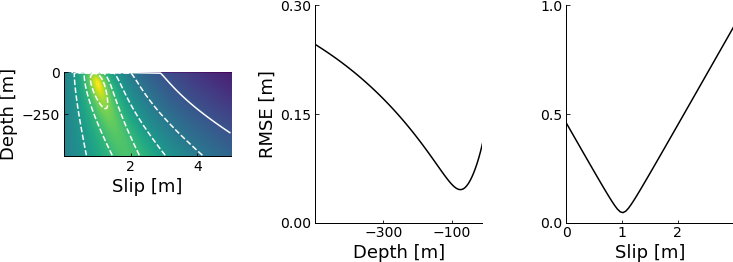

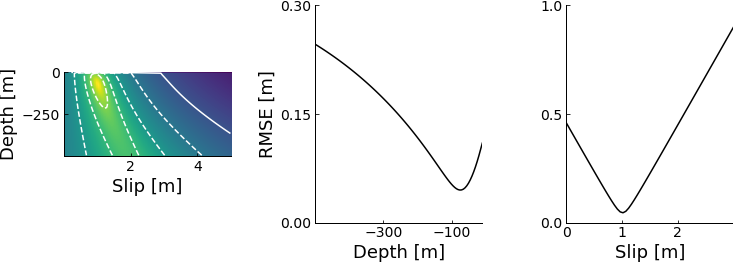

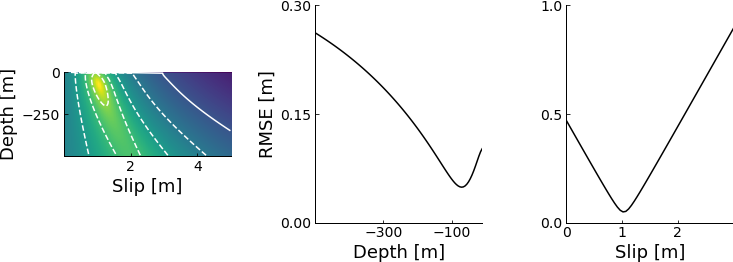

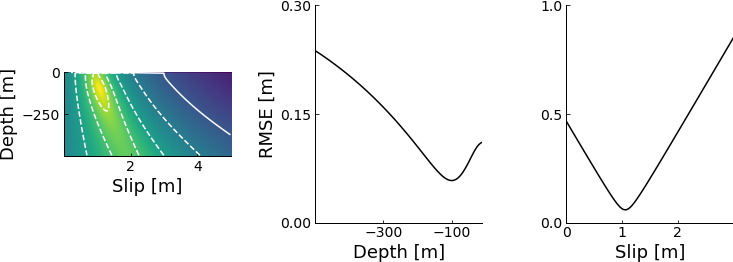

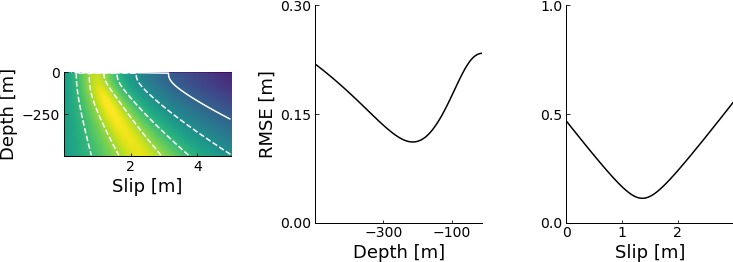

In [484]:
for uobs, utrue, dx in zip(uicps, us, dxs):
    plot_rmse_1d(uobs, utrue, dx=dx)

## RMSE - 2D disp. field

In [568]:
def plot_rmse_2d_dipslip(dx=50):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    
    filename = f'results/sfm/dip_slip/HSLSurvey101419_utm_s310.00_d90.00_dep100.00_ss0.00_ds1.00_ICP_w{dx:.2f}_str{dx / 2:.2f}.pkl'
    x, y, ux, uy, uobs, residual, mask = load_and_mask_results(filename, iterations=2)
    x, y = np.meshgrid(x, y)
    
    depths = np.linspace(0, 500, num=100) + 0.01
    slips = np.linspace(0, 5, num=100) + 0.01
    rmses = np.full((len(depths), len(slips)), fill_value=np.nan)
    extent = (min(slips), max(slips), min(depths), max(depths))

    for i, depth in enumerate(depths):
        for j, s in enumerate(slips):
            _, upred = model_2d(depth, slip_ds=s, slip_ss=0, x=x, y=y)
            rmses[i, j] = rmse(upred, uobs)        
    
    im = ax[0].imshow(np.log10(rmses), extent=extent, cmap='viridis_r')
    _ = ax[0].contour(np.log10(rmses), [-1, -0.75, -0.5, -0.25, 0], extent=extent, colors='w', origin='upper')
    #plt.colorbar(im, label='log$_{10}$ RMSE [m]', orientation='horizontal', shrink=0.5, pad=0.25, ax=ax[0])
    ax[0].set_aspect(0.005)
    ax[0].set_xlabel('Slip [m]')
    ax[0].set_ylabel('Depth [m]')
    
    idx = np.where(rmses == rmses.min())
    i = idx[0][0]
    j = idx[1][0]
    
    ax[1].plot(depths, rmses[:, j], 'k-')
    ax[1].set_xlabel('Depth [m]')
    ax[1].set_ylabel('RMSE [m]')
    
    ax[2].plot(slips, rmses[i, :], 'k-')
    ax[2].set_xlabel('Slip [m]')

    plt.subplots_adjust(wspace=0.5)

    print(f'Min. RMSE: dx = {dx/2:.1f} m depth = {depths[i]:.1f} m, slip = {slips[j]:.1f} m, RMSE = {rmses[i, j]:.2f} m')

In [569]:
def plot_rmse_2d_strikeslip(dx=50):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    
    filename = f'results/sfm/strike_slip/HSLSurvey101419_utm_s310.00_d90.00_dep100.00_ss1.00_ds0.00_ICP_w{dx:.2f}_str{dx / 2:.2f}.pkl'
    x, y, ux, uy, uz, residual, mask = load_and_mask_results(filename, iterations=2)
    x, y = np.meshgrid(x, y)
    
    uobs, _ = rotate(ux, uy, theta=50)
    
    depths = np.linspace(0, 500, num=100) + 0.01
    slips = np.linspace(0, 5, num=100) + 0.01
    rmses = np.full((len(depths), len(slips)), fill_value=np.nan)
    extent = (min(slips), max(slips), min(depths), max(depths))

    for i, depth in enumerate(depths):
        for j, s in enumerate(slips):
            upred, _ = model_2d(depth, slip_ds=0, slip_ss=s, x=x, y=y)
            rmses[i, j] = rmse(upred, uobs)        
    
    im = ax[0].imshow(np.log10(rmses), extent=extent, cmap='viridis_r')
    _ = ax[0].contour(np.log10(rmses), [-1, -0.75, -0.5, -0.25, 0], extent=extent, colors='w', origin='upper')
    #plt.colorbar(im, label='log$_{10}$ RMSE [m]', orientation='horizontal', shrink=0.5, pad=0.25, ax=ax[0])
    ax[0].set_aspect(0.005)
    ax[0].set_xlabel('Slip [m]')
    ax[0].set_ylabel('Depth [m]')
    
    idx = np.where(rmses == rmses.min())
    i = idx[0][0]
    j = idx[1][0]
    
    ax[1].plot(depths, rmses[:, j], 'k-')
    ax[1].set_xlabel('Depth [m]')
    ax[1].set_ylabel('RMSE [m]')
    
    ax[2].plot(slips, rmses[i, :], 'k-')
    ax[2].set_xlabel('Slip [m]')

    plt.subplots_adjust(wspace=0.5)

    print(f'Min. RMSE: dx = {dx/2:.1f} m depth = {depths[i]:.1f} m, slip = {slips[j]:.1f} m, RMSE = {rmses[i, j]:.2f} m')

Min. RMSE: dx = 5.0 m depth = 500.0 m, slip = 0.0 m, RMSE = 75485555.86 m
Min. RMSE: dx = 12.5 m depth = 247.5 m, slip = 1.1 m, RMSE = 0.65 m
Min. RMSE: dx = 25.0 m depth = 181.8 m, slip = 1.0 m, RMSE = 0.56 m
Min. RMSE: dx = 50.0 m depth = 146.5 m, slip = 1.0 m, RMSE = 0.24 m


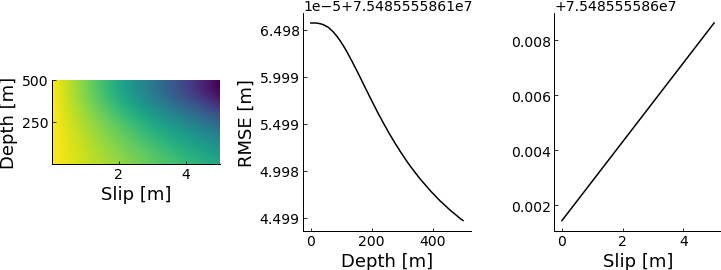

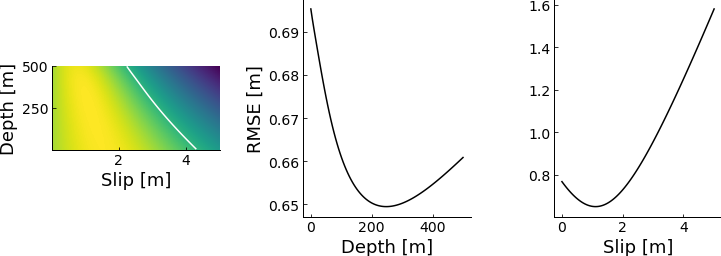

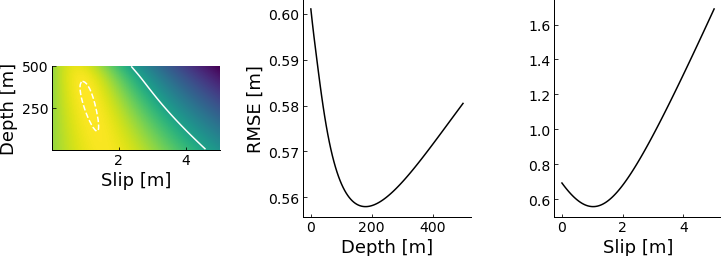

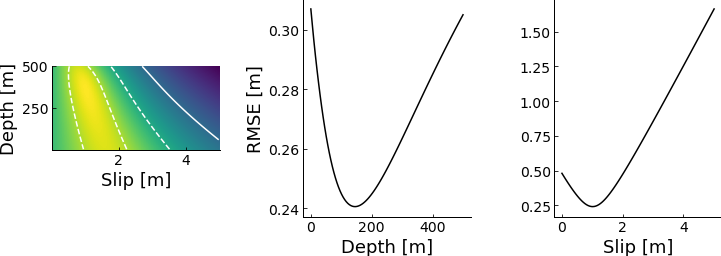

In [570]:
windows = [10, 25, 50, 100]
for w in windows:
    plot_rmse_2d_dipslip(dx=w)

In [ ]:
windows = [50]
for w in windows:
    plot_rmse_2d_strikeslip(dx=w)

## RMSE - 2D disp. field, both strike and dip slip

In [582]:
def plot_rmse_2param_dipslip(dx=50, num=100):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    
    filename = f'results/sfm/dip_slip/HSLSurvey101419_utm_s310.00_d90.00_dep100.00_ss0.00_ds1.00_ICP_w{dx:.2f}_str{dx / 2:.2f}.pkl'
    x, y, ux, uy, uobs, residual, mask = load_and_mask_results(filename, iterations=2)
    x, y = np.meshgrid(x, y)
    
    depths = np.linspace(0, 500, num=num) + 0.01
    slips = np.linspace(0, 5, num=num) + 0.01
    rmses = np.full((len(depths), len(slips), len(slips)), fill_value=np.nan)
    extent = (min(slips), max(slips), min(depths), max(depths))

    for i, depth in enumerate(depths):
        for j, ds in enumerate(slips):
            for k, ss in enumerate(slips):
                _, upred = model_2d(depth, slip_ds=ds, slip_ss=ss, x=x, y=y)
                rmses[i, j, k] = rmse(upred, uobs)        
    
    im = ax[0].imshow(np.log10(rmses[:, :, 0]), extent=extent, cmap='viridis_r')
    _ = ax[0].contour(np.log10(rmses[:, :, 0]), levels=3, extent=extent, colors='w', origin='upper')
    #plt.colorbar(im, label='log$_{10}$ RMSE [m]', orientation='horizontal', shrink=0.5, pad=0.25, ax=ax[0])
    ax[0].set_aspect(0.005)
    ax[0].set_xlabel('Slip [m]')
    ax[0].set_ylabel('Depth [m]')
    ax[0].invert_yaxis()
    
    idx = np.where(rmses == rmses.min())
    i = idx[0][0]
    j = idx[1][0]
    k = idx[2][0]
    
    ax[1].plot(depths, rmses[:, j, k], 'k-')
    ax[1].set_xlabel('Depth [m]')
    ax[1].set_ylabel('RMSE [m]')
    
    ax[2].plot(slips, rmses[i, :, k], 'k-', label='Dip slip')    
    ax[2].plot(slips, rmses[i, j, :], 'k--', label='Strike slip')
    ax[2].set_xlabel('Slip [m]')
    ax[2].legend(loc='upper left')

    plt.subplots_adjust(wspace=0.5)

    print(f'Min. RMSE: dx = {dx/2:.1f} m depth = {depths[i]:.1f} m, dip slip = {slips[j]:.1f} m, strike slip = {slips[k]:.1f} m, RMSE = {rmses[i, j, k]:.2f} m')

In [583]:
def plot_rmse_2param_strikeslip(dx=50, num=100):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    
    filename = f'results/sfm/strike_slip/HSLSurvey101419_utm_s310.00_d90.00_dep100.00_ss1.00_ds0.00_ICP_w{dx:.2f}_str{dx / 2:.2f}.pkl'
    x, y, ux, uy, uz, residual, mask = load_and_mask_results(filename, iterations=2)
    x, y = np.meshgrid(x, y)
    uobs, _ = rotate(ux, uy, theta=50)
    
    depths = np.linspace(0, 500, num=num) + 0.01
    slips = np.linspace(0, 5, num=num) + 0.01
    rmses = np.full((len(depths), len(slips), len(slips)), fill_value=np.nan)
    extent = (min(slips), max(slips), min(depths), max(depths))

    for i, depth in enumerate(depths):
        for j, ds in enumerate(slips):
            for k, ss in enumerate(slips):
                upred, _ = model_2d(depth, slip_ds=ds, slip_ss=ss, x=x, y=y)
                rmses[i, j, k] = rmse(upred, uobs)        
    
    im = ax[0].imshow(np.log10(rmses[:, :, 0]), extent=extent, cmap='viridis_r')
    _ = ax[0].contour(np.log10(rmses[:, :, 0]), levels=3, extent=extent, colors='w', origin='upper')
    #plt.colorbar(im, label='log$_{10}$ RMSE [m]', orientation='horizontal', shrink=0.5, pad=0.25, ax=ax[0])
    ax[0].set_aspect(0.005)
    ax[0].set_xlabel('Slip [m]')
    ax[0].set_ylabel('Depth [m]')
    ax[0].invert_yaxis()
    
    idx = np.where(rmses == rmses.min())
    i = idx[0][0]
    j = idx[1][0]
    k = idx[2][0]
    
    ax[1].plot(depths, rmses[:, j, k], 'k-')
    ax[1].set_xlabel('Depth [m]')
    ax[1].set_ylabel('RMSE [m]')
    
    ax[2].plot(slips, rmses[i, :, k], 'k-', label='Dip slip')    
    ax[2].plot(slips, rmses[i, j, :], 'k--', label='Strike slip')
    ax[2].set_xlabel('Slip [m]')
    ax[2].legend(loc='upper left')

    plt.subplots_adjust(wspace=0.5)

    print(f'Min. RMSE: dx = {dx/2:.1f} m depth = {depths[i]:.1f} m, dip slip = {slips[j]:.1f} m, strike slip = {slips[k]:.1f} m, RMSE = {rmses[i, j, k]:.2f} m')

In [ ]:
windows = [50]
for w in windows:
    plot_rmse_2param_dipslip(dx=w, num=25)

In [ ]:
windows = [50]
for w in windows:
    plot_rmse_2param_strikeslip(dx=w, num=25)

## Bootstrap

In [418]:
us = np.load('profiles/lidar_ds_applied.npy', allow_pickle=True)
uicps = np.load('profiles/lidar_ds_observed.npy', allow_pickle=True)

In [294]:
def get_bootstrap_dists(x, uobs, nboot=100, **kwargs):
    depths_b = []
    slips_b = []

    for i in range(nboot):
        idx = choice(range(len(uobs)), size=len(uobs), replace=True)
        xboot = xp[idx]
        uboot = uobsc[idx]
        phat, pcov = curve_fit(model_1d, xboot, uboot, **kwargs)
        depths_b.append(phat[0])
        slips_b.append(phat[1])
    
    return depths_b, slips_b

In [389]:
def plot_bootstrap_dists(depths_b, slips_b):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    ax[0].hist(depths_b, bins=30, color='0.5', ec='w')
    ymin, ymax = ax[0].set_ylim()
    ax[0].vlines(np.nanmedian(depths_b), ymin, ymax, colors='r', linestyles='-')
    ax[0].vlines(np.nanpercentile(depths_b, [2.5, 97.5]), ymin, ymax, colors='k', linestyles='--')
    ax[0].set_xlabel('Depth [m]')
    ax[0].set_ylabel('Count')

    ax[1].hist(slips_b, bins=30, color='0.5', ec='w')
    ymin, ymax = ax[1].set_ylim()
    ax[1].vlines(np.nanmedian(slips_b), ymin, ymax, colors='r', linestyles='-')
    ax[1].vlines(np.nanpercentile(slips_b, [2.5, 97.5]), ymin, ymax, colors='k', linestyles='--')
    ax[1].set_xlabel('Slip [m]')
    ax[1].set_yticklabels([])
    
    hist, x, y, im = ax[2].hist2d(slips_b, depths_b, bins=20, density=True)
    dx = np.diff(x)[0]
    dy = np.diff(y)[0]
    ax[2].clear()
    c = ax[2].contour(x[1:] - dx, y[1:] - dy, hist, levels=3, colors='k', linestyles='-')
    ax[2].clabel(c, fmt='%2.1f', colors='k', fontsize=14)
    ax[2].set_xlabel('Slip [m]')
    ax[2].set_ylabel('Depth [m]')

## Dip slip

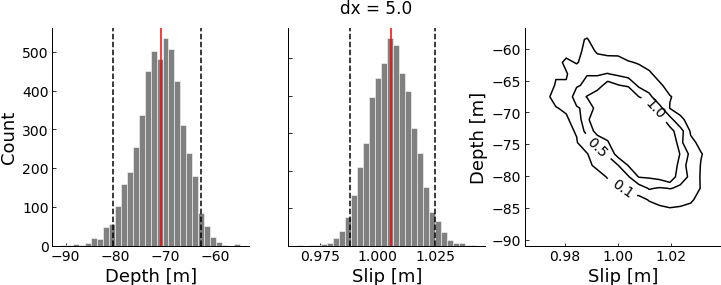

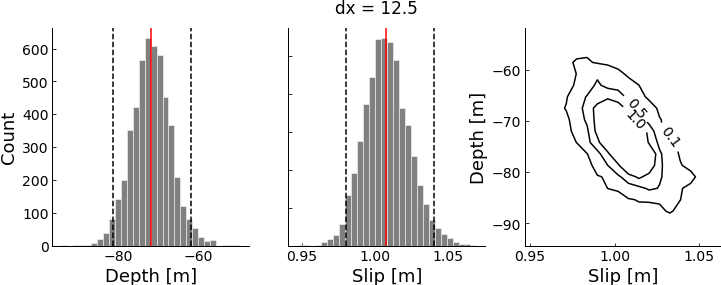

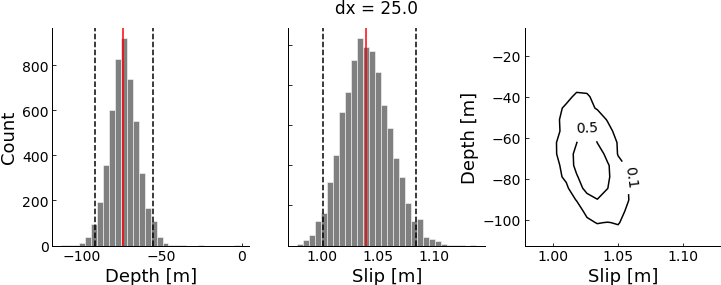

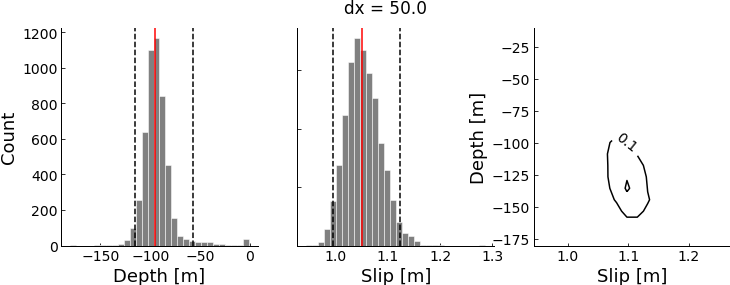

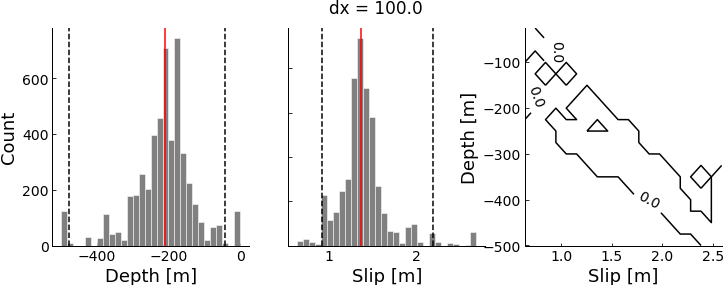

In [394]:
median_depths = []
median_slips = []
upper_depths = []
upper_slips = []
lower_depths = []
lower_slips = []

for uobs, utrue, dx in zip(uicps, us, dxs):
    xp, uobsc, utruec = center_profiles(uobs, utrue, dx=dx)
    depths_b, slips_b = get_bootstrap_dists(xp, uobsc, nboot=5000, p0=[-1, 0.1], bounds=([-500, 0.1], [-1, 10]))
    median_depths.append(np.nanmedian(depths_b))
    median_slips.append(np.nanmedian(slips_b))
    upper_depths.append(np.nanpercentile(depths_b, 97.5))
    upper_slips.append(np.nanpercentile(slips_b, 97.5))
    lower_depths.append(np.nanpercentile(depths_b, 2.5))
    lower_slips.append(np.nanpercentile(slips_b, 2.5))
    plot_bootstrap_dists(depths_b, slips_b)
    plt.suptitle(f'dx = {dx:.1f}')

dxs = np.array(dxs)
median_depths = np.array(median_depths)
median_slips = np.array(median_slips)
upper_depths = np.array(upper_depths)
lower_depths = np.array(lower_depths)
upper_slips = np.array(upper_slips)
lower_slips = np.array(lower_slips)

Text(0, 0.5, 'Depth [m]')

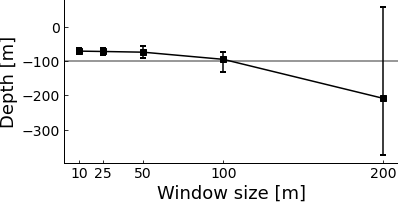

In [395]:
plt.figure(figsize=(6, 3))
bounds_depths = np.vstack([upper_depths - median_depths, median_depths - lower_depths])
plt.errorbar(2 * dxs, median_depths, yerr=bounds_depths, fmt='ks-', capsize=3, capthick=2, label='Dip slip')
xmin, xmax = plt.xlim()
plt.hlines(-100, xmin, xmax, colors='0.6', linestyles='-', lw=2, zorder=-1)
plt.xticks(2 * dxs)
#plt.yticks([0, -250, -500])
plt.xlim([xmin, xmax])
plt.xlabel('Window size [m]')
plt.ylabel('Depth [m]')

(0.5, 209.5)

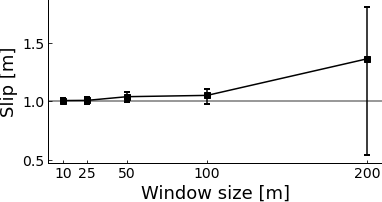

In [396]:
plt.figure(figsize=(6, 3))
bounds_slips = np.vstack([upper_slips - median_slips, median_slips - lower_slips])
plt.errorbar(2 * dxs, median_slips, yerr=bounds_slips, fmt='ks-', capsize=3,  capthick=2, label='Dip slip')
xmin, xmax = plt.xlim()
plt.hlines(1, xmin, xmax, colors='0.6', linestyles='-', lw=2, zorder=-1)
plt.xticks(2 * dxs)
plt.xlabel('Window size [m]')
plt.ylabel('Slip [m]')
plt.xlim([xmin, xmax])


## Strike slip

In [418]:
us = np.load('profiles/lidar_ss_applied.npy', allow_pickle=True)
uicps = np.load('profiles/lidar_ss_observed.npy', allow_pickle=True)

[-2.70221884e+04  1.10435410e+01]
[-2.80734417e+04  1.04480883e+01]
[-2.68600446e+04  1.30275582e+01]
[-2.52931165e+04  1.72228255e+01]
[-24204.0504666      26.86338043]


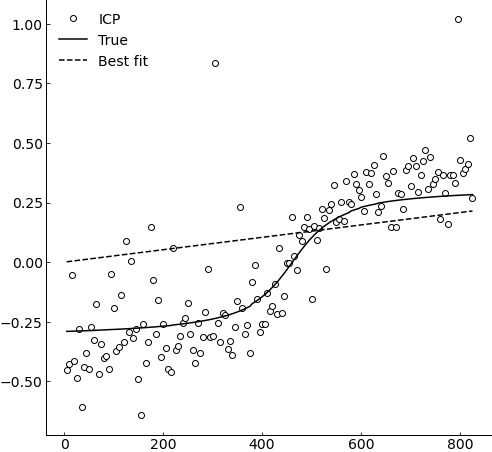

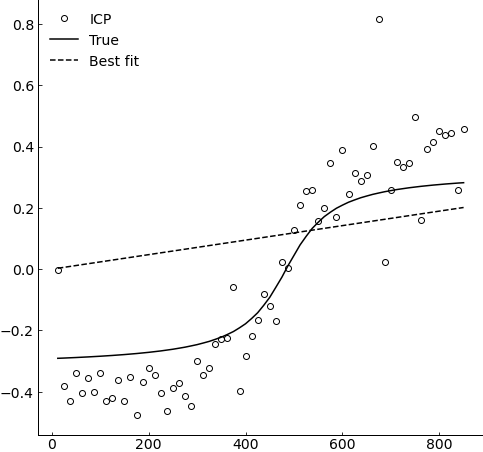

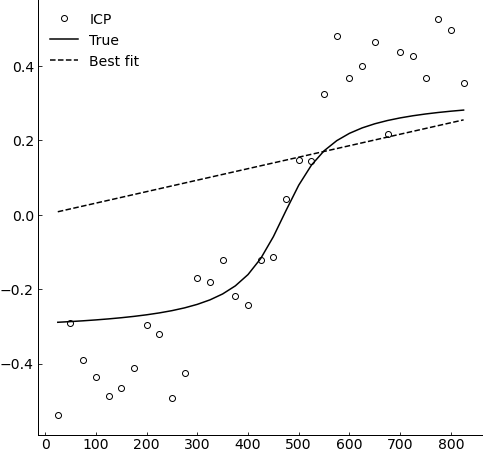

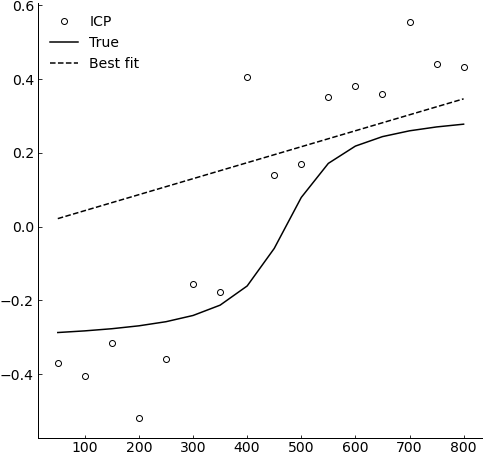

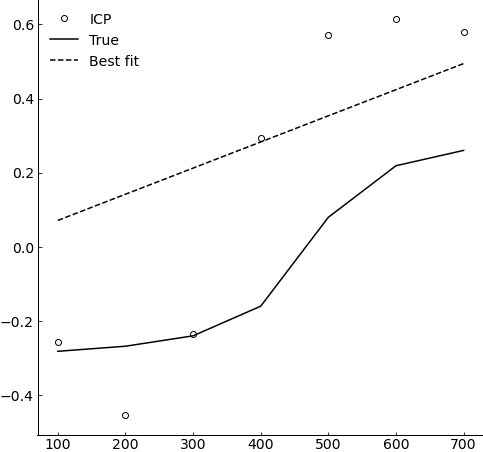

In [430]:
for uobs, utrue, dx in zip(uicps, us, dxs):
    xp, uobsc, utruec = center_profiles(-uobs, utrue, dx=dx)
    x = dx * np.arange(1, len(uobs) + 1)
    phat, pcov = curve_fit(model_1d, x, -uobs)
    uhat = model_1d(x, *phat)
    print(phat)

    plt.figure()
    plt.plot(x, -uobs, 'wo', mec='k', label='ICP')
    plt.plot(x, utrue, 'k-', label='True')
    plt.plot(x, uhat, 'k--', label='Best fit')
    plt.legend()

IndexError: arrays used as indices must be of integer (or boolean) type

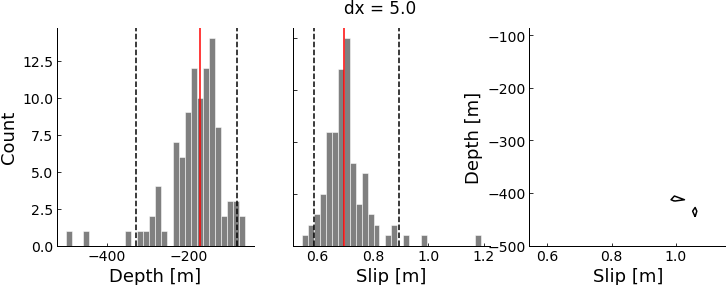

In [422]:
median_depths = []
median_slips = []
upper_depths = []
upper_slips = []
lower_depths = []
lower_slips = []

for uobs, utrue, dx in zip(uicps, us, dxs):
    xp, uobsc, utruec = center_profiles(-uobs, utrue, dx=dx)
    depths_b, slips_b = get_bootstrap_dists(xp, uobsc, nboot=100, p0=[-1, 0.1], bounds=([-500, 0.1], [-1, 10]))
    median_depths.append(np.nanmedian(depths_b))
    median_slips.append(np.nanmedian(slips_b))
    upper_depths.append(np.nanpercentile(depths_b, 97.5))
    upper_slips.append(np.nanpercentile(slips_b, 97.5))
    lower_depths.append(np.nanpercentile(depths_b, 2.5))
    lower_slips.append(np.nanpercentile(slips_b, 2.5))
    plot_bootstrap_dists(depths_b, slips_b)
    plt.suptitle(f'dx = {dx:.1f}')

dxs = np.array(dxs)
median_depths = np.array(median_depths)
median_slips = np.array(median_slips)
upper_depths = np.array(upper_depths)
lower_depths = np.array(lower_depths)
upper_slips = np.array(upper_slips)
lower_slips = np.array(lower_slips)

In [ ]:
plt.figure(figsize=(6, 3))
bounds_depths = np.vstack([upper_depths - median_depths, median_depths - lower_depths])
plt.errorbar(2 * dxs, median_depths, yerr=bounds_depths, fmt='ks-', capsize=3, capthick=2, label='Dip slip')
xmin, xmax = plt.xlim()
plt.hlines(-100, xmin, xmax, colors='0.6', linestyles='-', lw=2, zorder=-1)
plt.xticks(2 * dxs)
#plt.yticks([0, -250, -500])
plt.xlim([xmin, xmax])
plt.xlabel('Window size [m]')
plt.ylabel('Depth [m]')

In [ ]:
plt.figure(figsize=(6, 3))
bounds_slips = np.vstack([upper_slips - median_slips, median_slips - lower_slips])
plt.errorbar(2 * dxs, median_slips, yerr=bounds_slips, fmt='ks-', capsize=3,  capthick=2, label='Dip slip')
xmin, xmax = plt.xlim()
plt.hlines(1, xmin, xmax, colors='0.6', linestyles='-', lw=2, zorder=-1)
plt.xticks(2 * dxs)
plt.xlabel('Window size [m]')
plt.ylabel('Slip [m]')
plt.xlim([xmin, xmax])
